In [1]:
!apt-get install tor
!service tor start
!pip install pyupbit
!pip install pybit

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tor is already the newest version (0.4.6.10-1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
 * Starting tor daemon...
   ...done.


In [2]:
import socket
import socks
import requests

socks.set_default_proxy(socks.SOCKS5, "127.0.0.1", 9050)
socket.socket = socks.socksocket
print(requests.get('https://httpbin.org/ip').text)

{
  "origin": "23.154.177.19"
}



In [3]:
import sqlite3
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
import time
import pyupbit
from pybit.unified_trading import HTTP
import yfinance as yf
import ipywidgets as widgets
from IPython.display import display

In [42]:
import time
from pybit.unified_trading import HTTP
import pandas as pd

# Bybit API session 초기화 (테스트넷)
session = HTTP(testnet=False)

def get_price_data(symbols, day, interval):
    price_data = {}
    price_diff_data = {}  # 가격 차이 데이터를 저장할 딕셔너리 추가

    # day를 밀리초로 변환
    end_time = int(time.time() * 1000)  # 현재 시간의 밀리초 타임스탬프
    start_time = end_time - (day * 24 * 60 * 60 * 1000)  # n일 전 시간 (밀리초)

    # 각 심볼에 대해 현물과 선물 가격 데이터를 가져오기
    for symbol in symbols:
        # 현물 데이터 (spot)
        spot_data = []
        futures_data = []

        # 요청 범위 설정 (600개 이하로 분할)
        step_size = 300  # 한 번에 요청할 수 있는 최대 데이터 수
        current_start = start_time

        while current_start < end_time:
            current_end = min(current_start + step_size * 60 * 60 * 1000, end_time)  # 각 요청 범위는 최대 600개의 데이터
            print(current_start)
            print(current_end)
            try:
                # 현물 데이터 요청
                spot_response = session.get_kline(
                    category="spot",   # 현물 카테고리
                    symbol=symbol + "USDT",  # 심볼 (예: BTCUSDT)
                    interval=interval,  # 데이터 간격 (1분, 1시간 등)
                    start=current_start,   # 시작 시간
                    end=current_end,      # 종료 시간
                    limit=step_size,
                )

                # 선물 데이터 요청
                futures_response = session.get_kline(
                    category="inverse",  # 선물 카테고리
                    symbol=symbol + "USDT",  # 심볼 (예: BTCUSD)
                    interval=interval,  # 데이터 간격
                    start=current_start,   # 시작 시간
                    end=current_end,      # 종료 시간
                    limit=step_size,
                )

                # API 응답 확인
                if 'result' in spot_response and 'result' in futures_response:
                    spot_prices = [(item[0], item[4]) for item in spot_response['result']['list']]
                    futures_prices = [(item[0], item[4]) for item in futures_response['result']['list']]

                    spot_data.extend(spot_prices)
                    futures_data.extend(futures_prices)
                else:
                    print(f"Error in data for {symbol}")
                    break

                current_start = current_end

                time.sleep(5)

            except Exception as e:
                print(f"Error fetching data for {symbol}: {e}")
                break

        # 현물과 선물 가격 데이터를 타임스탬프를 기준으로 합침
        merged_prices = []
        price_diff = []  # 가격 차이를 저장할 배열

        spot_index = 0
        futures_index = 0

        while spot_index < len(spot_data) and futures_index < len(futures_data):
            # 타임스탬프가 동일한 데이터만 합침
            spot_timestamp, spot_close = spot_data[spot_index]
            futures_timestamp, futures_close = futures_data[futures_index]

            # 문자열을 실수로 변환
            spot_close = float(spot_close)
            futures_close = float(futures_close)

            if spot_timestamp == futures_timestamp:
                merged_prices.append([spot_timestamp, spot_close, futures_close])
                price_diff.append([spot_timestamp, spot_close - futures_close])  # 가격 차이 계산
                spot_index += 1
                futures_index += 1
            elif spot_timestamp < futures_timestamp:
                spot_index += 1
            else:
                futures_index += 1

        # 가격 차이 데이터를 별도로 저장
        price_diff_data[symbol] = price_diff
        price_data[symbol] = merged_prices


    return price_data, price_diff_data




In [34]:
from datetime import datetime

timestamp_ms = 1711519200000

timestamp_s = timestamp_ms / 1000
dt_object = datetime.utcfromtimestamp(timestamp_s)

formatted_time = dt_object.strftime('%Y-%m-%d %H:%M:%S')

print(f"Converted time: {formatted_time}")


Converted time: 2024-03-27 06:00:00


In [43]:
import time
import pandas as pd
from datetime import datetime, timedelta
from pybit.unified_trading import HTTP

session = HTTP(testnet=False)


def get_funding_fees(symbols, day):
    """
    Bybit에서 symbols 리스트에 저장된 모든 심볼의 펀딩 비율을 가져와서 데이터프레임으로 저장한다.
    요청 수 제한을 초과하지 않도록 요청을 나눠서 한다.
    """
    end_time = int(time.time() * 1000)
    start_time = end_time - (day * 24 * 60 * 60 * 1000)
    all_funding_data = []

    for symbol in symbols:
        symbol_perp = f"{symbol}PERP"
        funding_data = []

        try:
            step_size = 600
            current_start = start_time


            while current_start < end_time:
                current_end = min(current_start + step_size * 60 * 60 * 1000, end_time)
                response = session.get_funding_rate_history(
                    category="linear",
                    symbol=symbol_perp,
                    startTime=current_start,
                    endTime=current_end,
                    limit=600
                )

                if "result" in response and response["result"]["list"]:
                    for entry in response["result"]["list"]:
                        funding_rate = float(entry["fundingRate"])
                        timestamp = int(entry["fundingRateTimestamp"]) // 1000
                        funding_time = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

                        funding_data.append([funding_time, funding_rate])

                current_start = current_end

                time.sleep(5)

            funding_df = pd.DataFrame(funding_data, columns=["Funding Time", "Funding Rate"])
            funding_df["Funding Time"] = pd.to_datetime(funding_df["Funding Time"])

            all_funding_data.append(funding_df)

            print(f"Funding fees merged for {symbol}")

        except Exception as e:
            print(f"Error fetching funding rate for {symbol}: {e}")

    if all_funding_data:
        final_funding_df = pd.concat(all_funding_data, ignore_index=True)
        return final_funding_df
    else:
        return pd.DataFrame(columns=["Funding Time", "Funding Rate"])


In [44]:
symbols = ["BTC"]
day = 50
interval = 60

data, price_diff = get_price_data(symbols, day, interval)

for symbol in symbols:
    print(f"Price data for {symbol}:")
    merged_df = pd.DataFrame(data[symbol], columns=["timestamp", "spot_close", "futures_close"])
    print(merged_df.head())
    print(f"Price difference data for {symbol}:")
    diff_df = pd.DataFrame(price_diff[symbol], columns=["timestamp", "price_diff"])
    print(diff_df)

funding_fees_df = get_funding_fees(symbols, day)

print(funding_fees_df)

1735138427064
1736218427064
Error fetching data for BTC: You have breached the ip rate limit or your ip is from the usa. (ErrCode: 403) (ErrTime: 14:53:48).
Request → GET https://api.bybit.com/v5/market/kline: category=spot&end=1736218427064&interval=60&limit=300&start=1735138427064&symbol=BTCUSDT.
Price data for BTC:
Empty DataFrame
Columns: [timestamp, spot_close, futures_close]
Index: []
Price difference data for BTC:
Empty DataFrame
Columns: [timestamp, price_diff]
Index: []
Error fetching funding rate for BTC: You have breached the ip rate limit or your ip is from the usa. (ErrCode: 403) (ErrTime: 14:53:48).
Request → GET https://api.bybit.com/v5/market/funding/history: category=linear&endTime=1737298428190&limit=600&startTime=1735138428190&symbol=BTCPERP.
Empty DataFrame
Columns: [Funding Time, Funding Rate]
Index: []


In [20]:
import numpy as np

def tanh(x):
    return np.tanh(x)

def log_scale(x, base=10):
    return np.log(x + 1e-8) / np.log(base)

def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]

    res_price = []
    res_funding = []

    for i in range(n - 1):
        price_diff = log_scale(block[i + 1][0]) - log_scale(block[i][0])
        res_price.append(tanh(price_diff))

        funding_diff = block[i + 1][1] - block[i][1]
        res_funding.append(tanh(funding_diff))

    return np.array([res_price + res_funding])

data = [
    [100000000, 0.02],
    [102000000, 0.03],
    [105000000, 0.02],
    [107000000, 0.01],
    [110000000, 0.05],
    [112000000, 0.04],
]

t = 5
n = 2

state = getState(data, t, n)
print(state)


[[ 0.00782518 -0.00999967]]


In [7]:
import matplotlib.pyplot as plt

data = price_diff.iloc[:, [1]]

symbol = "BTC"
price_diff_df = pd.DataFrame(price_diff[symbol], columns=["timestamp", "price_diff"])

plt.figure(figsize=(10, 6))
plt.plot(price_diff_df['timestamp'], price_diff_df['price_diff'], label=f'{symbol} Price Difference')
plt.xlabel("Timestamp")
plt.ylabel("Price Difference")
plt.title(f"Price Difference Between Spot and Futures for {symbol}")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

NameError: name 'price_diff' is not defined

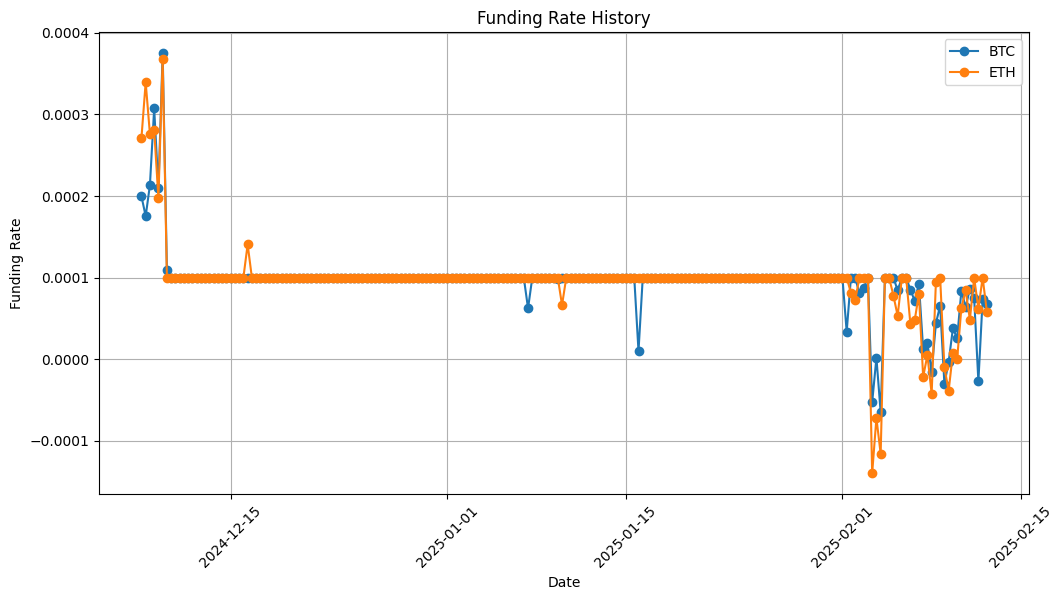

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

symbols = ["BTC", "ETH"]

def plot_funding_rates(symbols):
    """
    저장된 CSV 파일을 불러와 각 심볼별로 펀딩 비율을 그래프로 표시한다.
    """
    plt.figure(figsize=(12, 6))

    for symbol in symbols:
        csv_filename = f"{symbol}_funding_fees.csv"

        if not os.path.exists(csv_filename):
            print(f"파일 없음: {csv_filename}")
            continue

        df = pd.read_csv(csv_filename, parse_dates=["Funding Time"])
        df = df.sort_values("Funding Time")
        plt.plot(df["Funding Time"], df["Funding Rate"], label=symbol, marker="o")

    plt.xlabel("Date")
    plt.ylabel("Funding Rate")
    plt.title("Funding Rate History")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

plot_funding_rates(symbols)
